In [1]:
include("DSpectral.jl")
using .DSpectral
using PyPlot

In [ ]:
function run_peierls(;
        T, ω₀, λ,
        t = 1.0,
        occupation = 1e-4,
        μ_init = -2.0,
        nq = 128,
        ωs = range(-8., 8., step=0.01),
        η = 0.0,
        plot_spectral = false,
        verbose = false,
        maxiter = 50,
        run_response = false,
        self_consistent = true,
    )
    if !self_consistent && η == 0.
        throw(ArgumentError("η must be provided and nonzero for G0D0 (self_consistent = false)"))
    end

    g = sqrt(λ * ω₀ * t / 2)

    μ = μ_init
    # μ = -Inf
    # occupation = NaN

    ks = range(-π, π, length=nq+1)
    ωs_dense = ωs
    ks_dense = ks

    qpts = DSpectral.Kpoints(Vector(range(-π, π, length=nq+1)[1:end-1]), fill(1 / nq, nq))
    S = ElectronPhononSolver(DSpectral.PeierlsLatticeModel(g, ω₀, t, μ, T), ωs, ks, qpts; ks_dense, ωs_dense, η, occupation)
    
    if self_consistent  # scGD0
        ;
       # EPSpectral.ep_solve!(S; tol=1e-5, maxiter, update_μ = !isnan(occupation), verbose);
    else  # G0D0
        DSpectral.compute_self_energy!(S)
    end
    compute_spectral_function!(S)
    return (; S)
end


run_peierls (generic function with 1 method)

In [ ]:
μ = -Inf
nq = 1024
ωs = range(-8., 8., step=0.01)

T = 0.0
ω₀ = 1.0
λ = 0.5

η = 1e-2

println("=== ω₀ = $ω₀, λ = $λ, T = $T ===")

S = run_peierls(; ω₀, T, λ, μ_init = μ, nq, η, occupation = NaN, self_consistent = false).S

=== ω₀ = 1.0, λ = 0.5, T = 0.0 ===


In [ ]:
fig, plotaxes = subplots(2, 1, figsize=(5, 8))
ax = plotaxes[1]
vmax = maximum(S.As_dense)
img = plot_spectral_function!(ax, S; cmap="viridis", norm = PyPlot.matplotlib.colors.LogNorm(; vmin=vmax/1e3, vmax))
# img = plot_spectral_function!(ax, S; cmap="viridis", vmin = 0, vmax = vmax / 1)
# ax.set_ylim([-5, 4])
plotaxes[1].set_ylim(extrema(S.ωs))
# plotaxes[1].set_ylim([-5, -1])
colorbar(img; ax)

dos = dropdims(sum(S.As_dense[:, 1:end-1], dims = 2), dims = 2) .* step(S.ks_dense)
fermi = @. occ_fermion(S.ωs_dense - S.model.μ, S.model.T)
plotaxes[2].plot(S.ωs_dense, dos)
plotaxes[2].plot(S.ωs_dense, dos .* fermi)
plotaxes[2].plot(S.ωs_dense, cumsum(dos .* fermi))
plotaxes[2].set_yscale("log")

In [26]:
function run_atomic_chain(;
        T, ω₀, λ,
        t = 1.0,
        occupation = 1e-4,
        μ_init = -2.0,
        nq = 128,
        ωs = range(-8., 8., step=0.1),
        η = 0.0,
        plot_spectral = false,
        verbose = false,
        maxiter = 50,
        run_response = false,
        self_consistent = true,
    )
    if !self_consistent && η == 0.
        throw(ArgumentError("η must be provided and nonzero for G0D0 (self_consistent = false)"))
    end

    g = sqrt(λ * ω₀ * t / 2)
    M = 1
    C = 1
    a = 1
    m_imp = 0.5
    conc = 0.2


    μ = μ_init
    # μ = -Inf
    # occupation = NaN

    ks = range(-π, π, length=nq+1)
    ωs_dense = ωs
    ks_dense = ks

    qpts = DSpectral.Kpoints(Vector(range(-π, π, length=nq+1)[1:end-1]), fill(1 / nq, nq))
    S = PhononDefectSolver(DSpectral.SingleAtomicChainModel(M,C,a,m_imp,conc), ωs, ks, qpts; ks_dense, ωs_dense, η, occupation)
    #compute_phonon_self_energy!(S)
    compute_phonon_spectral_function!(S)

    return(; S)
end
    

run_atomic_chain (generic function with 1 method)

In [27]:
μ = -Inf
nq = 300
ωs = range(0., 4., step=0.02)

T = 0.0
ω₀ = 1.0
λ = 0.5

η = 1e-2

println("=== ω₀ = $ω₀, λ = $λ, T = $T ===")

S = run_atomic_chain(; ω₀, T, λ, μ_init = μ, nq=nq, ωs=ωs,η, occupation = NaN, self_consistent = false).S

=== ω₀ = 1.0, λ = 0.5, T = 0.0 ===


PhononDefectSolver(SingleAtomicChainModel(1.0, 1.0, 1.0, 0.5, 0.2), η = 0.01)
qpts     : 300 points, 
ωs       : 201 points, [0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18  …  3.82, 3.84, 3.86, 3.88, 3.9, 3.92, 3.94, 3.96, 3.98, 4.0]
ks       : 301 points, [-3.141592653589793, -3.120648702565861, -3.099704751541929, -3.078760800517997, -3.057816849494065, -3.036872898470133, -3.015928947446201, -2.9949849964222692, -2.9740410453983377, -2.9530970943744057  …  2.9530970943744057, 2.9740410453983377, 2.9949849964222692, 3.015928947446201, 3.036872898470133, 3.057816849494065, 3.078760800517997, 3.099704751541929, 3.120648702565861, 3.141592653589793]
ωs_dense : 201 points, 0.0:0.02:4.0
ks_dense : 301 points, -3.141592653589793:0.020943951023931952:3.141592653589793

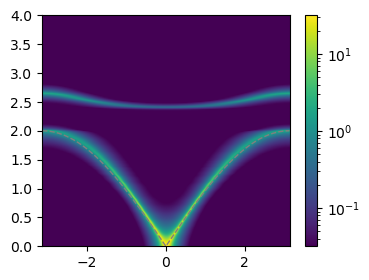

PyObject <matplotlib.colorbar.Colorbar object at 0x000001A41F6684A0>

In [25]:
fig, plotaxes = subplots(figsize=(4, 3))
ax = plotaxes
vmax = maximum(S.As_dense)
img = plot_phonon_spectral_function!(bare_band = true,chemical_potential = false,ax, S; cmap="viridis", norm = PyPlot.matplotlib.colors.LogNorm(; vmin=vmax/1e3, vmax))
# img = plot_spectral_function!(ax, S; cmap="viridis", vmin = 0, vmax = vmax / 1)
# ax.set_ylim([-5, 4])
#img = plot_phonon_spectral_function!(bare_band = true,chemical_potential = false,ax, S; cmap="viridis")
plotaxes.set_ylim(extrema(S.ωs))
# plotaxes[1].set_ylim([-5, -1])
colorbar(img; ax)



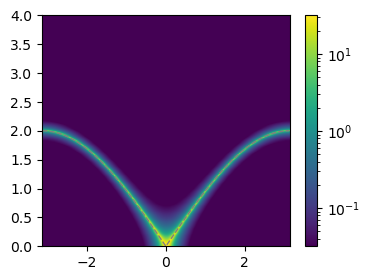

PyObject <matplotlib.colorbar.Colorbar object at 0x000001A41F0CDEE0>

In [28]:
fig, plotaxes = subplots(figsize=(4, 3))
ax = plotaxes
vmax = maximum(S.As_dense)
img = plot_phonon_spectral_function!(bare_band = true,chemical_potential = false,ax, S; cmap="viridis", norm = PyPlot.matplotlib.colors.LogNorm(; vmin=vmax/1e3, vmax))
# img = plot_spectral_function!(ax, S; cmap="viridis", vmin = 0, vmax = vmax / 1)
# ax.set_ylim([-5, 4])
#img = plot_phonon_spectral_function!(bare_band = true,chemical_potential = false,ax, S; cmap="viridis")
plotaxes.set_ylim(extrema(S.ωs))
# plotaxes[1].set_ylim([-5, -1])
colorbar(img; ax)